<a href="https://colab.research.google.com/github/AlexChek51/Neuro_teacher/blob/main/Neuro_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практическая работа реализованная в виде чат-бота, для дальнейшей доработки и  использования на практике в школе.

In [ ]:
!pip install --quiet sentence-transformers peft auto-gptq optimum accelerate ctransformers[cuda] torch transformers bitsandbytes datasets trl tiktoken python-dotenv nest_asyncio aiogram python-docx chromadb langchain langchain-openai langchain_community langchain-text-splitters 'arize-phoenix[evals]' nemoguardrails

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 256.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527

Настройка трассировки (tracing) для отслеживания выполнения кода и интеграция с инструментом Phoenix для анализа производительности и ошибок.

In [ ]:
%%writefile tracer.py
import asyncio
import nest_asyncio

try:
    import uvloop
    asyncio.set_event_loop_policy(asyncio.DefaultEventLoopPolicy())
except ImportError:
    pass

nest_asyncio.apply()

import phoenix as px
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations

# Настройка трассировки
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from opentelemetry import trace

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))
trace.set_tracer_provider(tracer_provider)
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

tracer = trace.get_tracer(__name__)

# Запуск Phoenix после настройки трассировки
session = px.launch_app()


Writing tracer.py


In [ ]:
%%writefile .env
API_TOKEN= введите токен
openai_api_key= введите ключ

Writing .env


Настройка и конфигурация бота

In [ ]:
%%writefile config.py
import os
from aiogram import Bot, Dispatcher

bot = Bot(token=os.getenv('API_TOKEN'))
dp = Dispatcher()

Writing config.py


1. Обработка запросов от пользователя и взаимодействие с OpenAI для генерации ответов.
2. Загрузка переменных окружения с использованием dotenv, в частности API-ключа OpenAI.
3. Создание шаблонов для запросов к модели (PromptTemplate), которые будут использоваться для генерации кратких изложений и ответов на вопросы.
4. Добавление фильрации запросов.

In [ ]:
%%writefile model.py
from dotenv import load_dotenv

from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain_openai import ChatOpenAI
from langchain import LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import (
    StuffDocumentsChain,
    LLMChain,
    ReduceDocumentsChain,
    MapReduceDocumentsChain,
)
import os
from langchain.prompts import PromptTemplate
from langchain.prompts import PromptTemplate
from tracer import tracer

# Загрузка переменных окружения
load_dotenv()

openai_api_key = os.getenv("openai_api_key")
os.environ['OPENAI_API_KEY'] = openai_api_key

prompt_full_book = """Ты нейро-учитель по геометрии. Тебе необходимо выделить основную информацию из конспекта урока, кратко.
Вот текст: {text}"""

user_question_prompt = """Вот текст конспекта урока:
{summary}

Ты нейро-учитель по геометрии. Теперь ответь на следующий вопрос излагая мысли как учитель:
{question}

Ответ должен быть на русском языке.
Использую информацию только из предоставленного текста.
Если не знаешь ответа, так и скажи. Не выдумывай!
Ответ:
"""


PROMPT_FULL_BOOK = PromptTemplate.from_template(prompt_full_book)
USER_QUESTION_PROMPT = PromptTemplate(input_variables=["summary", "question"], template=user_question_prompt)


def full_book(book, prompt):
    with tracer.start_as_current_span("FullBookProcessing"):
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o", openai_api_key=openai_api_key)
        span.set_attribute("model_name", llm.model_name)
        span.set_attribute("temperature", llm.temperature)
        llm_chain = LLMChain(llm=llm, prompt=prompt)
        response = llm_chain.run(book)
        span.set_attribute("input_text", book)
        span.set_attribute("response", response)
    return response

def filter_response(response, forbidden_words=None, min_length=10, max_length=250):
    if forbidden_words is None:
        forbidden_words = ["некорректно", "неподобающий контент", "спам", "урод"]

    # Фильтрация по длине
    if len(response) < min_length or len(response) > max_length:
        return "Извините, ваш запрос слишком короткий или длинный, переформулируйте вопрос."

    # Фильтрация по запрещенным словам
    for word in forbidden_words:
        if word.lower() in response.lower():
            return "Вы используете нецензурные слова. Пожалуйста, переформулируйте свой вопрос."

    return response

def user_question(summary, question):
    # Применяем фильтрацию к вопросу пользователя
    filtered_question = filter_response(question)

    # Если фильтр возвращает сообщение об ошибке, сразу возвращаем его
    if filtered_question != question:
        return filtered_question

    with tracer.start_as_current_span("UserQuestionProcessing"):
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
        span.set_attribute("model_name", llm.model_name)
        span.set_attribute("temperature", llm.temperature)
        llm_chain = LLMChain(llm=llm, prompt=USER_QUESTION_PROMPT)
        response = llm_chain.run(summary=summary, question=question)
        span.set_attribute("input_text", summary)
        span.set_attribute("input_question", question)
        span.set_attribute("response", response)

    return response


Writing model.py


Создание пользовательского интерфейса (UI) с клавиатурами в боте и структура данных для классов и глав.


In [ ]:
%%writefile reply.py
from aiogram.types import ReplyKeyboardMarkup, KeyboardButton

# Определение начальной клавиатуры
start_kb = ReplyKeyboardMarkup(
    keyboard=[
        [
            KeyboardButton(text='Выберите класс'),
        ]
    ],
    resize_keyboard=True,
    input_field_placeholder='Что Вас интересует?'
)

# Словарь с данными по главам для каждого класса
class_chapters = {
    '7_класс': ['Глава_1_Начальные_геометрические_сведения', 'Глава 2: Треугольники',
                'Глава 3: Параллельные прямые и их свойства', 'Глава 4: Окружность, хорды и диаметр. Их свойства'],

    '8 класс': ['В разработке'],
    '9 класс': ['В разработке'],
    '10 класс': ['В разработке'],
    '11 класс': ['В разработке'],
}

# Словарь с данными по темам для каждой главы в каждом классе
class_chapter_topics = {
    '7_класс': {
        'Глава_1_Начальные_геометрические_сведения': ['Тема_1_Простейшие_геометрические_объекты', 'Тема_2_Многоугольник, ломаная', 'Тема_3_Смежные_и_вертикальные_углы', 'Тема_4_Измерение_линейных_и_угловых_величин, вычисление_отрезков_и_углов'],
        'Глава 2: Треугольники': ['Тема 1: Периметр и площадь фигур, составленных из прямоугольников', 'Тема 2: Понятие о равных треугольниках и первичные представления о равных ',
                                  'Тема 3: Три признака равенства треугольников ', 'Тема 4: Признаки равенства прямоугольных треугольников ',
                                  'Тема 5: Свойство медианы прямоугольного треугольника, проведённой к гипотенузе ', 'Тема 6: Равнобедренные и равносторонние треугольники ',
                                  'Тема 7: Признаки и свойства равнобедренного треугольника ', 'Тема 8: Неравенства в геометрии ',
                                  'Тема 9: Прямоугольный треугольник с углом в 30° '],
        'Глава 3: Параллельные прямые и их свойства': ['Тема 1: Параллельные прямые, их свойства', 'Тема 2: Пятый постулат Евклида',
                                                       'Тема 3: Накрест лежащие, соответственные и односторонние углы, образованные ', 'Тема 4: Признак параллельности прямых через равенство расстояний от точек ',
                                                       'Тема 4: Сумма углов треугольника', 'Тема 5: Внешние углы треугольника'],
        'Глава 4: Окружность, хорды и диаметр. Их свойства': ['Тема 1: Касательная к окружности', 'Тема 2: Окружность, вписанная в угол',
                                                              'Тема 3: Понятие о ГМТ, применение в задачах', 'Тема 4: Биссектриса и серединный перпендикуляр как геометрические места точек',
                                                              'Тема 5: Окружность, описанная около треугольника', 'Тема 6: Окружность, вписанная в треугольник',
                                                              'Тема 7: Простейшие задачи на построение']
    },

    # Добавить остальные классы и их главы с темами
}

# Определение клавиатуры с выбором классов
classes_kb = ReplyKeyboardMarkup(
    keyboard=[[KeyboardButton(text=class_name)] for class_name in class_chapters.keys()],
    resize_keyboard=True
)

Writing reply.py


Определение доступных команд для бота.

In [ ]:
%%writefile bot_cmds_list.py
from aiogram.types import BotCommand

private = [BotCommand(command='start', description='Приветствие')
           ]

Writing bot_cmds_list.py


 Обработка пользовательских сообщений и выполнение соответствующих действий.

In [ ]:
%%writefile user_private_handlers.py
from dotenv import load_dotenv

# Загружаем переменные окружения из .env файла
load_dotenv()

import os
import logging
from aiogram import types, Router, F
from aiogram.filters import CommandStart, Command, or_f
from aiogram.exceptions import TelegramForbiddenError
import reply as reply
from aiogram.types import ReplyKeyboardMarkup, KeyboardButton
from config import bot, dp
from model import full_book,user_question, PROMPT_FULL_BOOK, USER_QUESTION_PROMPT
from docx import Document
import tiktoken


# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

user_private_router = Router()

# Загрузка API ключа OpenAI из переменных окружения
openai_api_key = os.getenv("OPENAI_API_KEY")

# Основной путь к хранилищу
BASE_URL = '/content/drive/MyDrive/summaries_of_the_topics/'  # Замените на ваш URL

def get_file_url(selected_class, selected_chapter, selected_topic):
    return f'{BASE_URL}class/{selected_class}/chapter/{selected_chapter}/{selected_topic}.docx'

@user_private_router.message(CommandStart())
async def cmd_start(message: types.Message):
    greeting = (
        '''Испытываешь трудности в геометрии?

На помощь спешит НЕЙРОУЧИТЕЛЬ👩‍🏫
Вместе с тобой:
🗯 повторим теорию;
🗯 и проверим знания снова!

Кстати👆 Если у тебя возникли трудности,
нейро-учитель даже ответит на вопросы.

Всё еще не веришь???
Выбирай класс и вперед к знаниям 🦉📚'''
    )
    try:
        await message.answer(greeting, reply_markup=reply.start_kb)
    except TelegramForbiddenError:
        logger.warning(f"Bot was blocked by the user: {message.from_user.id}")

def read_docx(file_path):
    doc = Document(file_path)
    text = []
    for para in doc.paragraphs:
        text.append(para.text)
    return "\n".join(text)

@user_private_router.message(or_f(Command("classes"), (F.text.lower() == 'выберите класс')))
async def cmd_classes(message: types.Message):
    try:
        await message.reply("Пожалуйста, выберите класс:", reply_markup=reply.classes_kb)
    except TelegramForbiddenError:
        logger.warning(f"Bot was blocked by the user: {message.from_user.id}")

conversations = {}

@user_private_router.message(lambda message: message.text in reply.class_chapters.keys())
async def show_chapters(message: types.Message):
    selected_class = message.text
    chapters = reply.class_chapters[selected_class]

    chapters_kb = ReplyKeyboardMarkup(
        keyboard=[[KeyboardButton(text=chapter)] for chapter in chapters],
        resize_keyboard=True
    )

    conversations[message.from_user.id] = {'selected_class': selected_class}

    try:
        await message.reply(f"Вы выбрали {selected_class}. Пожалуйста, выберите главу:", reply_markup=chapters_kb)
    except TelegramForbiddenError:
        logger.warning(f"Bot was blocked by the user: {message.from_user.id}")

@user_private_router.message(lambda message: message.text in [chapter for chapters in reply.class_chapters.values() for chapter in chapters])
async def show_topics(message: types.Message):
    selected_chapter = message.text
    user_data = conversations.get(message.from_user.id, {})
    selected_class = user_data.get('selected_class')

    if selected_class:
        topics = reply.class_chapter_topics[selected_class].get(selected_chapter, ["Нет доступных тем"])
        topics_kb = ReplyKeyboardMarkup(
            keyboard=[[KeyboardButton(text=topic)] for topic in topics],
            resize_keyboard=True
        )

        if message.from_user.id in conversations:
            conversations[message.from_user.id]['selected_chapter'] = selected_chapter
        else:
            conversations[message.from_user.id] = {'selected_class': selected_class, 'selected_chapter': selected_chapter}

        try:
            await message.reply(f"Вы выбрали {selected_chapter}. Пожалуйста, выберите тему:", reply_markup=topics_kb)
        except TelegramForbiddenError:
            logger.warning(f"Bot was blocked by the user: {message.from_user.id}")

@user_private_router.message(lambda message: message.text in [
    topic for topics in reply.class_chapter_topics.get(
        conversations.get(message.from_user.id, {}).get('selected_class', ''),
        {}
    ).values() for topic in topics
])
async def provide_lesson_summary(message: types.Message):
    selected_topic = message.text
    user_id = message.from_user.id
    user_data = conversations.get(user_id, {})
    selected_class = user_data.get('selected_class')
    selected_chapter = user_data.get('selected_chapter')

    if selected_class and selected_chapter:
        file_path = get_file_url(selected_class, selected_chapter, selected_topic)

        try:
            if not os.path.isfile(file_path):
                logger.error(f"Файл не найден: {file_path}")
                await message.reply(f"Файл не найден: {file_path}")
                return

            file_text = read_docx(file_path)

            # Определяем метод суммаризации в зависимости от количества токенов
            encoding = tiktoken.encoding_for_model('gpt-4o')
            num_tokens = len(encoding.encode(file_text))
            summary = full_book(file_text, PROMPT_FULL_BOOK)

            # Отправляем краткое содержание темы пользователю
            await message.reply(f"Вы выбрали тему: {selected_topic}\n\nКраткое содержание:\n\n{summary}")

            # Сохранение данных в сессии
            if user_id in conversations:
                conversations[user_id]['file_text'] = file_text
                conversations[user_id]['summary'] = summary
            else:
                conversations[user_id] = {
                    'selected_class': selected_class,
                    'selected_chapter': selected_chapter,
                    'file_text': file_text,
                    'summary': summary
                }

        except Exception as e:
            logger.error(f"Ошибка при обработке файла: {e}")
            await message.reply(f"Произошла ошибка при обработке файла: {e}")
    else:
        await message.reply("Пожалуйста, выберите класс и главу сначала.")


@user_private_router.message(lambda message: message.from_user.id in conversations)
async def handle_user_questions(message: types.Message):
    user_id = message.from_user.id
    user_data = conversations.get(user_id, {})
    summary = user_data.get('summary')

    if summary:
        try:
            question = message.text
            # Генерация ответа
            bot_response = user_question(summary, question)
            await message.reply(bot_response)
        except Exception as e:
            logger.error(f"Ошибка при обработке вопроса пользователя: {e}")
            await message.reply("Произошла ошибка при обработке вашего вопроса. Попробуйте снова.")
    else:
        await message.reply("Сначала выберите тему, чтобы получить краткое содержание.")



Writing user_private_handlers.py


Запуск бота и всех необходимых настроек

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import asyncio
from aiogram import types
from aiogram.types import BotCommandScopeAllPrivateChats
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

from tracer import session
from config import bot, dp
from bot_cmds_list import private
from user_private_handlers import user_private_router


# Запуск процесса поллинга новых апдейтов
async def main():
    await bot.set_my_commands(commands=private, scope=types.BotCommandScopeAllPrivateChats())
    if user_private_router.parent_router is None:
        dp.include_router(user_private_router)
    await dp.start_polling(bot)

print(f"🚀 Открой Phoenix UI для просмотра результата трассировки по ссылке: {session.url}")

# Запуск бота
if __name__ == "__main__":
    asyncio.run(main())

ERROR:opentelemetry.instrumentation.instrumentor:DependencyConflict: requested: "llama-index-core >= 0.10.43" but found: "None"


🌍 To view the Phoenix app in your browser, visit https://qekdsh8w4s1-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
🚀 Открой Phoenix UI для просмотра результата трассировки по ссылке: https://qekdsh8w4s1-496ff2e9c6d22116-6006-colab.googleusercontent.com/


WARNI [aiogram.dispatcher] Received SIGINT signal


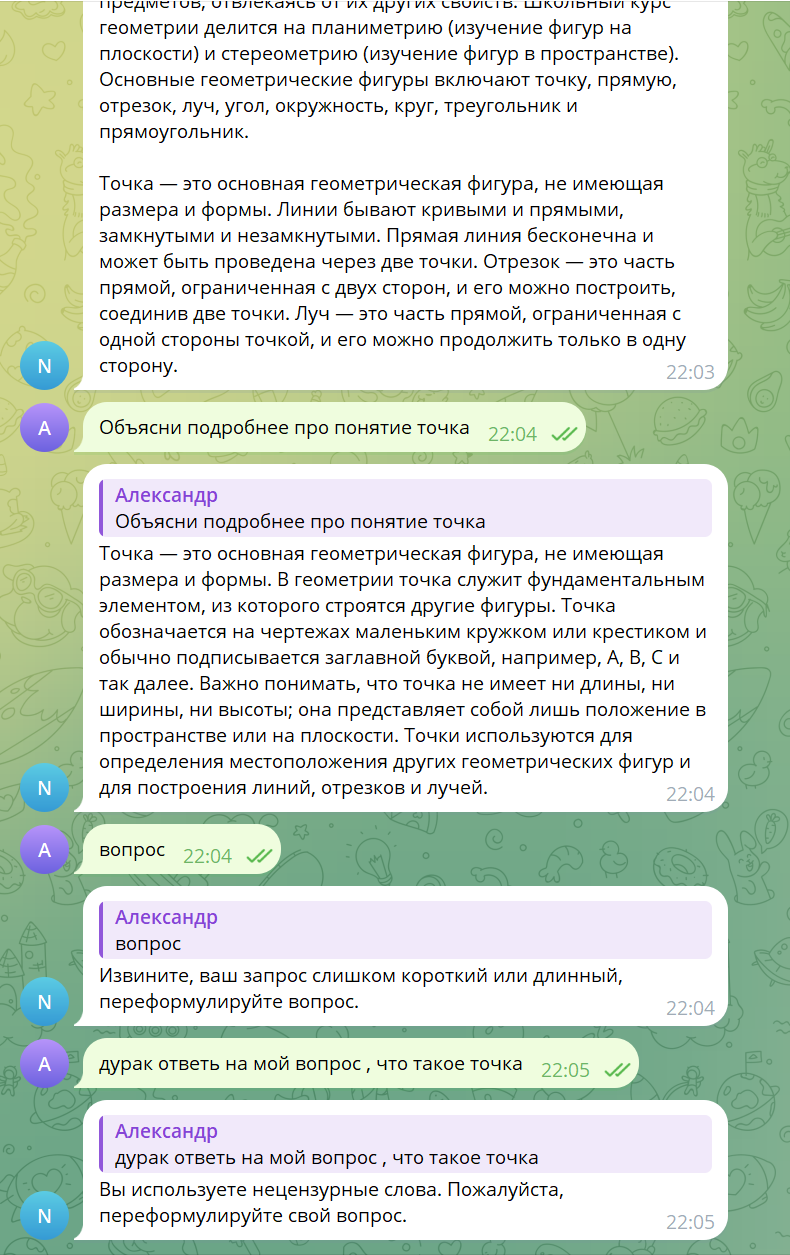

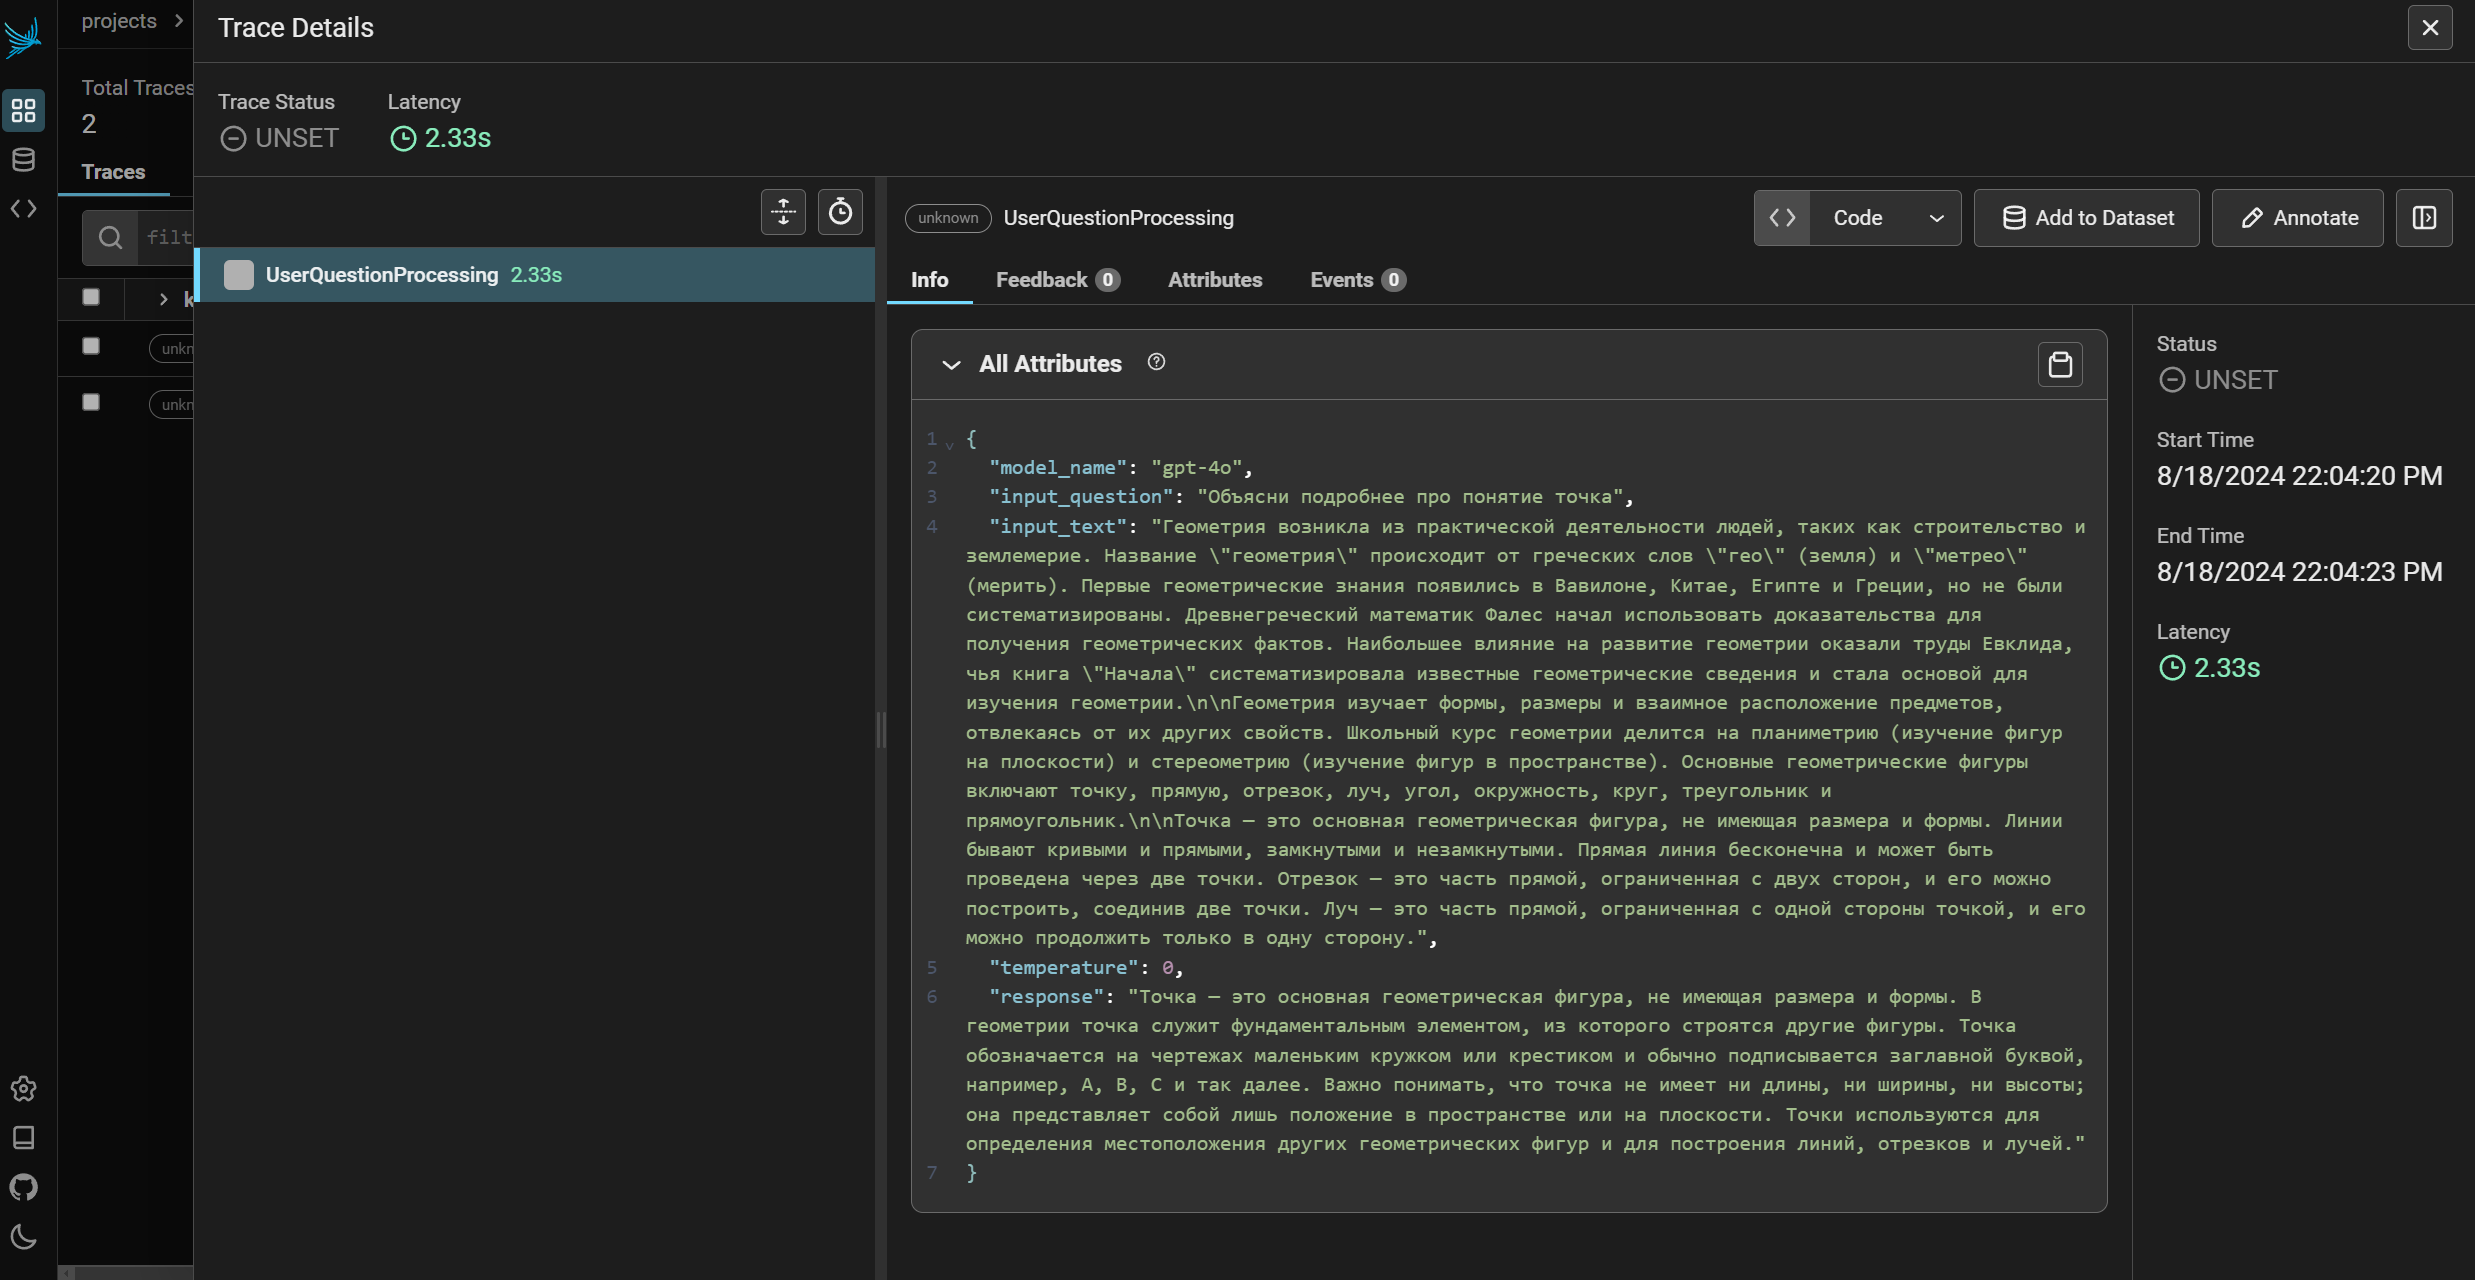

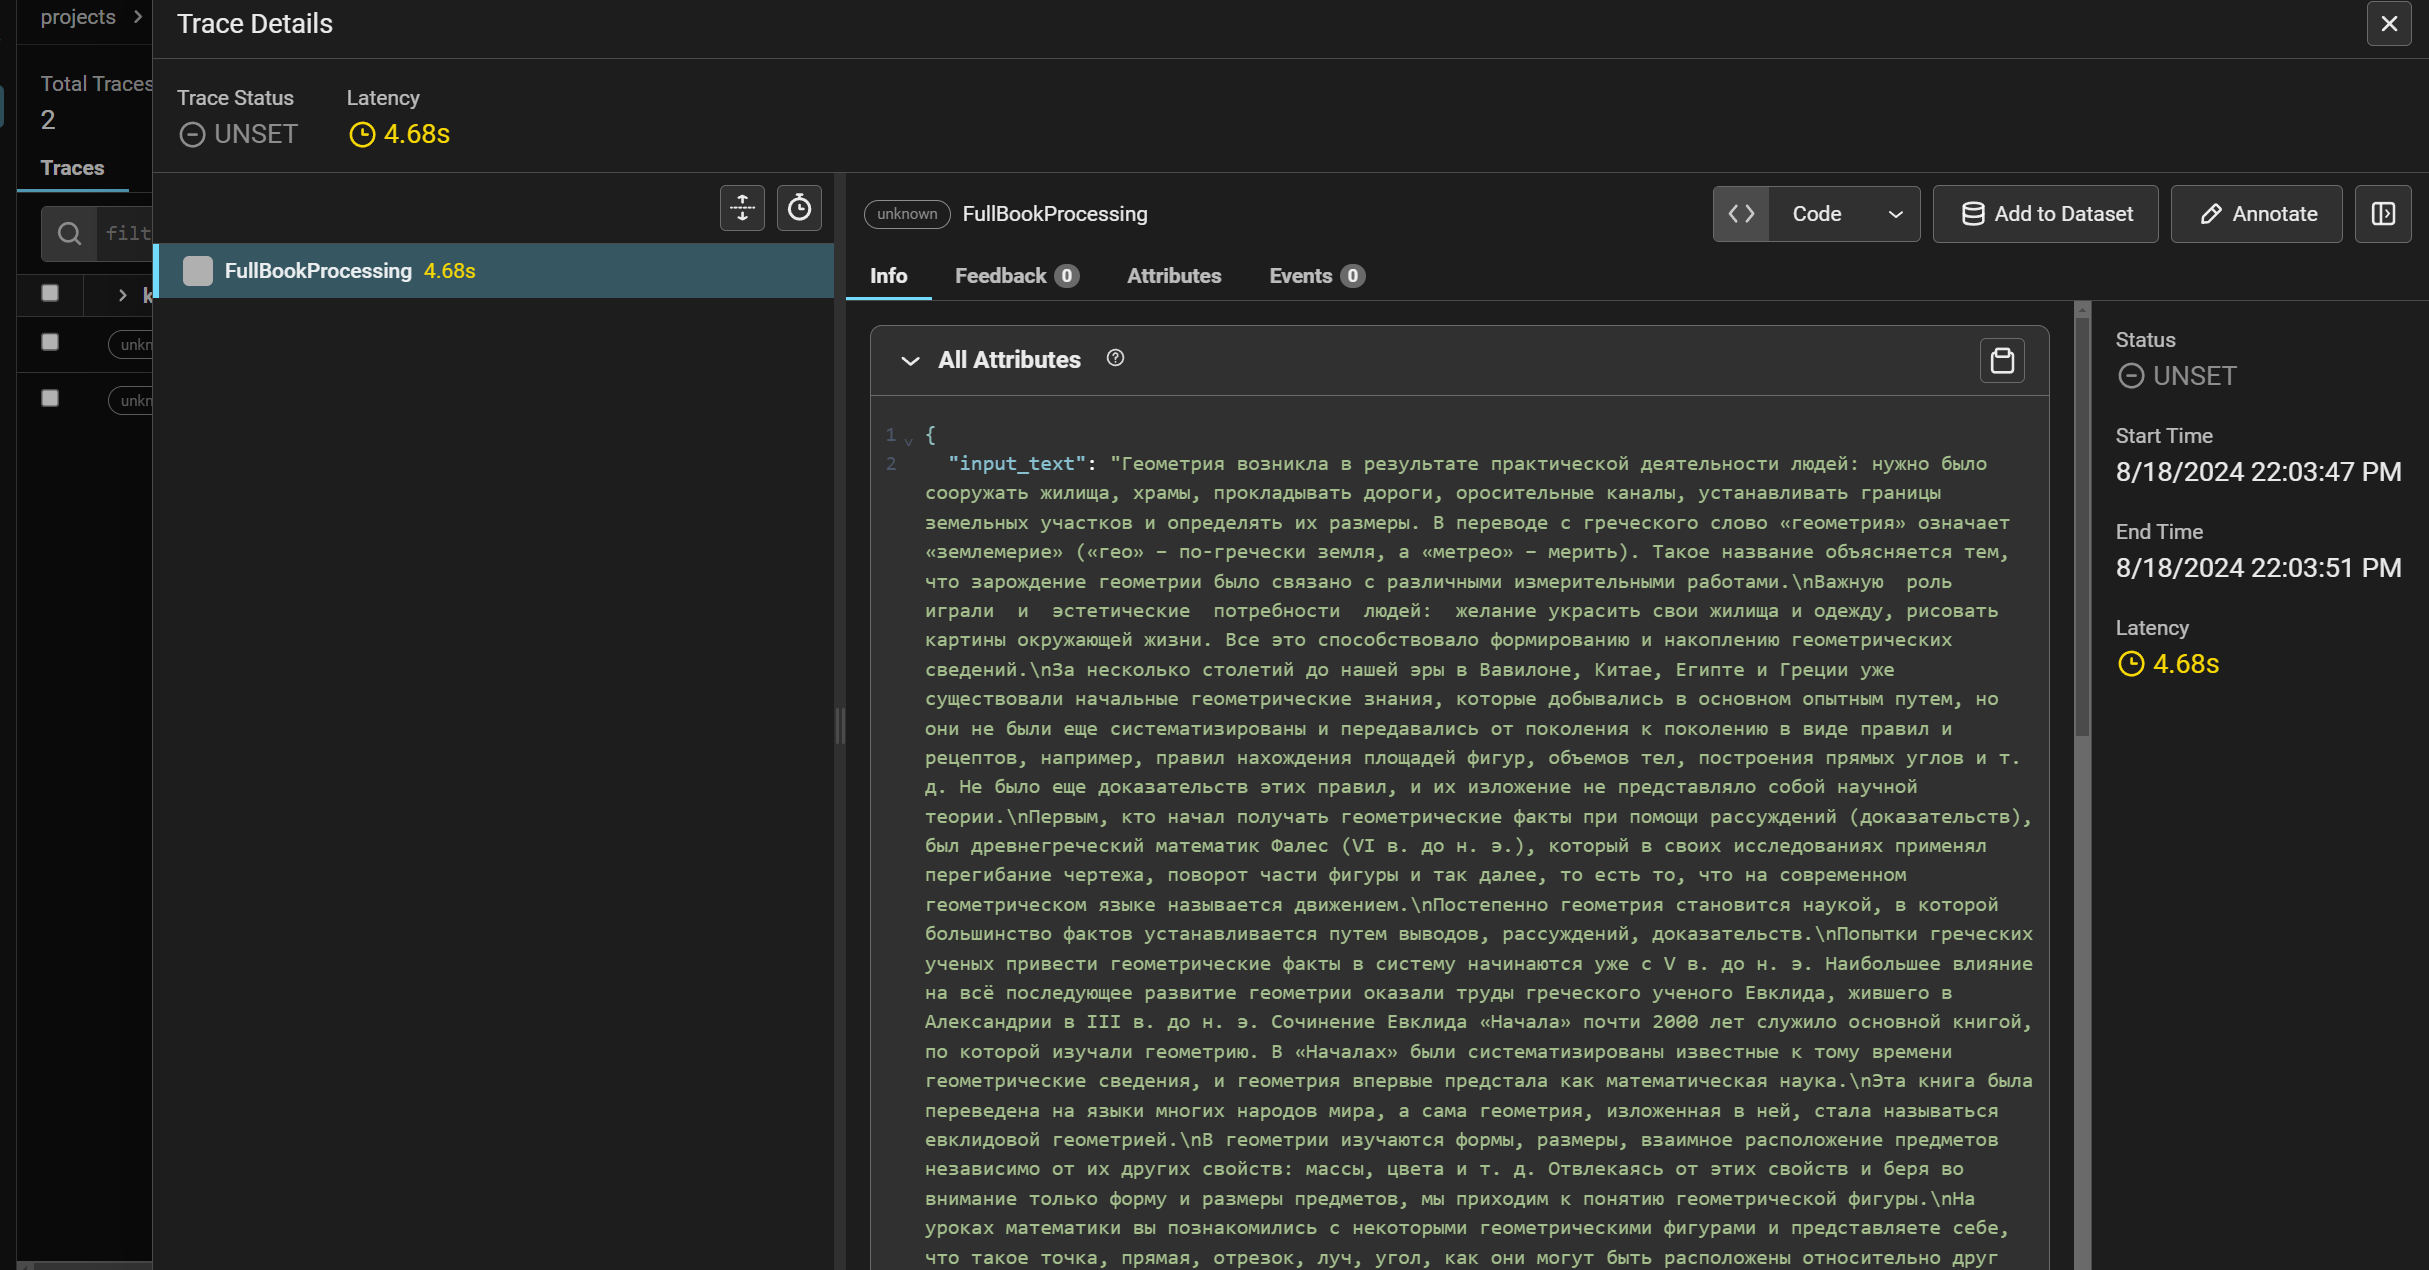